In [1]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import mplfinance as mpf
import pandas as pd
import bisect
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime,timedelta
from tqdm import tqdm, trange

In [2]:
client = CryptoHistoricalDataClient()

In [3]:
def get_data(start, end = None, ticker = "BTC", plot = True):
    global client
    def preprocess(data):
        data = data.reset_index(level = "timestamp").reset_index(level= "symbol")

        data = data[["open", "high", "low", "close", "volume", "timestamp"]]

        data.index = data["timestamp"]
        data.index = pd.to_datetime(data.index)
        data.drop(columns = ["timestamp"], axis = 1, inplace = True)

        return data

    if end is None:
        end = datetime.now()

    timeframe = TimeFrame.Minute

    request_params = CryptoBarsRequest(
        symbol_or_symbols=[f"{ticker}/USD"],
        timeframe=timeframe,
        start=start,
        end=end
    )

    btc_bars = client.get_crypto_bars(request_params)
    data = btc_bars.df

    data = preprocess(data)

    if plot:
        mpf.plot(data, type='candle', mav=(10, 20), volume=True, title=f"{ticker} Candlestick Chart", style='charles')
    return data

In [4]:
def resample(df, sample = 'H'):
    df = df.resample(sample).agg({
        'open': 'first',   # First open price in the hour
        'high': 'max',     # Maximum high price in the hour
        'low': 'min',      # Minimum low price in the hour
        'close': 'last',   # Last close price in the hour
        'volume': 'sum'    # Total volume in the hour
    }).dropna() 
    
    return df

In [5]:
def candleplot(df):
    mpf.plot(df, type='candle', mav=(10, 20), volume=True, title=f"Candlestick Chart", style='charles')
    return

In [6]:
def fractal_fill(df, window_length = 5):
    def bearish_fractal(df, i, window_length):
        flag = 1
        left = i - int(window_length / 2)
        right = i + int(window_length / 2)

        for j in range(left, i):
            flag *= int(df.iloc[j]["high"] < df.iloc[j + 1]["high"])
            
        for j in  range(i, right):
            flag *= int(df.iloc[j]["high"] > df.iloc[j + 1]["high"])
        return bool(flag)

    def bullish_fractal(df, i, window_length):
        flag = 1
        left = i - int(window_length / 2)
        right = i + int(window_length / 2)

        for j in range(left, i):
            flag *= int(df.iloc[j]["low"] > df.iloc[j + 1]["low"])

        for j in range(i, right):
            flag *= int(df.iloc[j]["low"] < df.iloc[j + 1]["low"])
        return bool(flag)
    
    N = len(df)
    df["fractal_type"] = None
    i = 0
    for _, row in tqdm(df.iterrows(), total = N):
        if (i - window_length / 2) < 0 or (i +  window_length) >= N:
            i += 1
            continue
        
        if bearish_fractal(df, i, window_length):
            df.loc[df.index[i], "fractal_type"] = "bearish"
        if bullish_fractal(df, i, window_length):
            df.loc[df.index[i], "fractal_type"] = "bullish"
        i += 1

    return df

In [11]:
def find_closest(x, timestamps):
    index = bisect.bisect_left(timestamps, x)
    return index, timestamps[index - 1]

In [25]:
def tendency(index, signal = "bearish", use = '4h'):
    global timestamps_4h, timestamps_30m, data_4h, data_30m

    if use == '4h':
        timestamps = timestamps_4h
        data = data_4h
    if use == '30m':
        timestamps = timestamps_30m
        data = data_30m

    if index < 4:
        return False
        
    first = timestamps[index - 4]
    second = timestamps[index - 3]
    third = timestamps[index - 2]
    fourth = timestamps[index - 1]

    if signal == "bearish":
        if ((data.loc[first, "high"] < data.loc[second, "high"]) and (data.loc[second, "high"] < data.loc[third, "high"]) and (data.loc[third, "high"] > data.loc[fourth, "high"])):
            return True
    if signal == "bullish":
        if ((data.loc[first, "low"] > data.loc[second, "low"]) and (data.loc[second, "low"] > data.loc[third, "low"]) and (data.loc[third, "low"] < data.loc[fourth, "low"])):
            return True
    return False

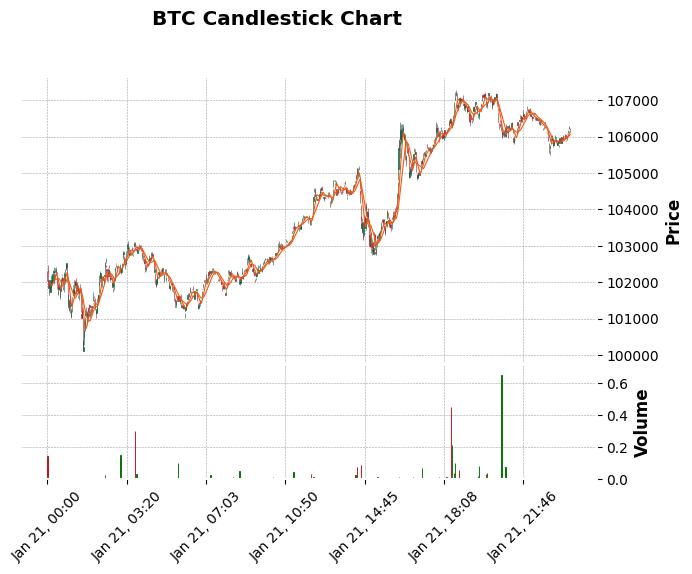

100%|██████████| 145/145 [00:00<00:00, 4032.02it/s]


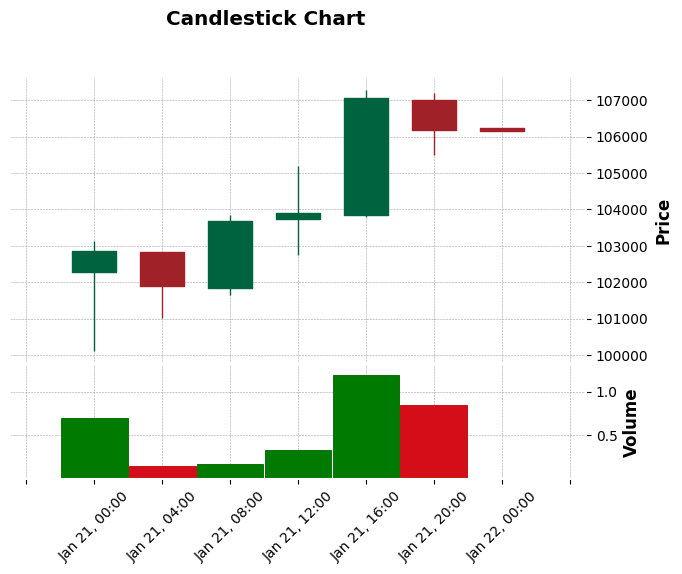

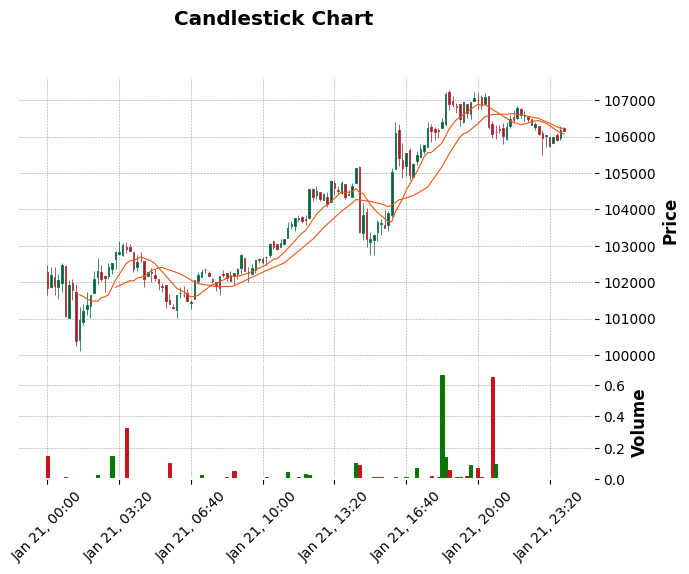

(None,
 None,
 Empty DataFrame
 Columns: [open, high, low, close, volume, fractal_type, signal]
 Index: [])

In [27]:
data_minute = get_data(start = datetime(2025, 1, 21), end = datetime(2025, 1, 22))
data_4h = resample(data_minute, '4H')
data_10m = resample(data_minute, '10Min')
data_30m = resample(data_minute, '30Min')

data_4h_filled = fractal_fill(data_4h)
data_minute_filled = fractal_fill(data_minute)
data_10m_filled = fractal_fill(data_10m)
data_30m_filled = fractal_fill(data_30m)

timestamps_4h = list(data_4h_filled.index) #GLOBAL PYTHON OBJECT -> `tendency` function dependency
timestamps_30m = list(data_30m.index) #GLOBAL OBJECT

data_10m_filled["signal"] = None
i = 0
for _, row in tqdm(data_10m_filled.iterrows(), total = len(data_10m_filled)):
    time = data_10m_filled.index[i]
    if data_10m_filled.loc[time, "fractal_type"] is not None: #bullish or bearish
        index, closest = find_closest(time, timestamps_30m)
        if data_10m_filled.loc[time, "fractal_type"] == "bearish":
            if index > 2:
                if tendency(index, "bearish", "30m"):
                    data_10m_filled.loc[time, "signal"] = "bearish"
        else:
            if index > 2:
                if tendency(index, "bullish", "30m"):
                    data_10m_filled.loc[time, "signal"] = "bullish"
    i += 1

candleplot(data_4h),  candleplot(data_10m), data_10m_filled[data_10m_filled["signal"] == "bearish"]

In [28]:
data_10m_filled[data_10m_filled["signal"] == "bullish"]

,open,high,low,close,volume,fractal_type,signal
timestamp,,,,,,,
2025-01-21 06:40:00+00:00,101436.673,101517.800,101276.053,101462.054,0.0000,bullish,bullish
2025-01-21 08:40:00+00:00,102264.665,102264.665,101910.610,102168.830,0.0508,bullish,bullish


In [31]:
data_10m_filled[data_10m_filled["signal"] == "bearish"]

,open,high,low,close,volume,fractal_type,signal
timestamp,,,,,,,


In [ ]:
# Bigger timeframes - 2months
# check profit after 4hr and 8hr
# buying or selling on basis of signals - long / short